#### model.py

In [1]:
import numpy as np
import torch 
import torch.nn as nn
from itertools import chain
import os


def create_modules(blocks):
    """
    Constructs module list of layer blocks from module configuration in blocks
    """
    hyperparameters = blocks[0]  #Captures the information about the input and pre-processing
    hyperparameters.update({
        'batch': int(hyperparameters['batch']),
        'subdivisions': int(hyperparameters['subdivisions']),
        'width': int(hyperparameters['width']),
        'height': int(hyperparameters['height']),
        'channels': int(hyperparameters['channels']),
        'optimizer': hyperparameters.get('optimizer'),
        'momentum': float(hyperparameters['momentum']),
        'decay': float(hyperparameters['decay']),
        'learning_rate': float(hyperparameters['learning_rate']),
        'burn_in': int(hyperparameters['burn_in']),
        'max_batches': int(hyperparameters['max_batches']),
        'policy': hyperparameters['policy'],
        'lr_steps': list(zip(map(int,   hyperparameters["steps"].split(",")),
                             map(float, hyperparameters["scales"].split(","))))
    })
    assert hyperparameters["height"] == hyperparameters["width"], \
        "Height and width should be equal! Non square images are padded with zeros."
    
    module_list = nn.ModuleList()
    prev_filters = hyperparameters["channels"]
    output_filters = []

    for index, x in enumerate(blocks[1:]):
        module = nn.Sequential()

        #check the type of block
        #create a new module for the block
        #append to module_list
        if (x["type"] == "convolutional"):
            #Get the info about the layer
            activation = x["activation"]
            try:
                batch_normalize = int(x["batch_normalize"])
                bias = False
            except:
                batch_normalize = 0
                bias = True

            filters= int(x["filters"])
            padding = int(x["pad"])
            kernel_size = int(x["size"])
            stride = int(x["stride"])

            if padding:
                pad = (kernel_size - 1) // 2
            else:
                pad = 0

            #Add the convolutional layer
            conv = nn.Conv2d(prev_filters, filters, kernel_size, stride, pad, bias = bias)
            module.add_module("conv_{0}".format(index), conv)

            #Add the Batch Norm Layer
            if batch_normalize:
                bn = nn.BatchNorm2d(filters)
                module.add_module("batch_norm_{0}".format(index), bn)

            #Check the activation. 
            #It is either Linear or a Leaky ReLU for YOLO
            if activation == "leaky":
                activn = nn.LeakyReLU(0.1, inplace = True)
                module.add_module("leaky_{0}".format(index), activn)
        
         #If it's an maxpooling layer
        elif x["type"] == "maxpool":
            kernel_size = int(x["size"])
            stride = int(x["stride"])
            if kernel_size == 2 and stride == 1:
                module.add_module(f"_debug_padding_{index}", nn.ZeroPad2d((0, 1, 0, 1)))
            maxpool = nn.MaxPool2d(kernel_size=kernel_size, stride=stride,
                                   padding=int((kernel_size - 1) // 2))
            module.add_module(f"maxpool_{index}", maxpool)
            
        #If it's an upsampling layer
        elif (x["type"] == "upsample"):
            stride = int(x["stride"])

            # For NearestSampling
            upsample = Upsample(scale_factor=int(x["stride"]), mode="nearest")
            # For Bilinear2dUpsampling
            # upsample = Upsample(scale_factor=int(x["stride"]), mode="'bilinear", align_corners=False)
            module.add_module("upsample_{}".format(index), upsample)
            
        #If it is a route layer
        elif (x["type"] == "route"):
            x["layers"] = x["layers"].split(',')
            #Start  of a route
            start = int(x["layers"][0])
            #end, if there exists one.
            try:
                end = int(x["layers"][1])
            except:
                end = 0
            #Positive anotation
            if start > 0: 
                start = start - index
            if end > 0:
                end = end - index
            
            if end == 0:
                # if -1 given and present layer is 20. 
                # we have to sum filters in 19th layer
                filters= output_filters[index + start]
            else:
                #If we are concatenating maps
                # suppose we have -1,28 and present layer is 20. 
                # we have sum filters in 19th and 28th layer
                filters = output_filters[index + start] + output_filters[index + end]
            
            route = EmptyLayer()  # that means this layer don't have any forward operation
            module.add_module("route_{0}".format(index), route)

        #shortcut corresponds to skip connection
        elif x["type"] == "shortcut":
            # filters = output_filters[1:][int(module_def["from"])]
            shortcut = EmptyLayer()
            module.add_module("shortcut_{}".format(index), shortcut)
        
        #Yolo is the detection layer
        elif x["type"] == "yolo":
            mask = x["mask"].split(",")
            mask = [int(x) for x in mask]

            anchors = x["anchors"].split(",")
            anchors = [int(a) for a in anchors]
            anchors = [(anchors[i], anchors[i+1]) for i in range(0, len(anchors),2)]
            anchors = [anchors[i] for i in mask]
            
            num_classes = int(x['classes'])
            yolo_layer = YOLOLayer(anchors, num_classes)
            module.add_module("Detection_{}".format(index), yolo_layer)

        module_list.append(module)
        prev_filters = filters
        output_filters.append(prev_filters)

    return (hyperparameters, module_list)


class Upsample(nn.Module):
    """ Upsample Layer """

    def __init__(self, scale_factor, mode="nearest"):
        super(Upsample, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, x):
        x = nn.functional.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        return x
    

class EmptyLayer(nn.Module):      # For Route and Shortcut Layer
    def __init__(self):
        super(EmptyLayer, self).__init__()


class YOLOLayer(nn.Module):
    """Detection layer"""

    def __init__(self, anchors, num_classes):
        super(YOLOLayer, self).__init__()
        self.num_anchors = len(anchors)  # 3
        self.num_classes = num_classes
        self.num_outputs = num_classes + 5  # number of outputs per anchor ( 5 + 80 )
        self.grid = torch.zeros(1)
        
        anchors = torch.tensor(list(chain(*anchors))).float().view(-1, 2)
        self.register_buffer('anchors', anchors)
        self.register_buffer(
            'anchor_grid', anchors.clone().view(1, -1, 1, 1, 2))
        
    def forward(self, x, inp_dim):
        """
        This function will take input_dimension_of_image,anchors and number of classes as input 
        """
        # x --> 4D feature map
        batch_size = x.shape[0]
        nx, ny = x.shape[2:4]
        stride =  inp_dim // x.size(2)   # factor by which current feature map reduced from input
        
        # x_y_offset = self.make_grid(nx, ny).to(x.device)
        yv, xv = torch.meshgrid([torch.arange(ny), torch.arange(nx)])
        x_y_offset = torch.stack((xv, yv), 2).view((1, 1, ny, nx, 2)).float().to(x.device)
        
        # Lets say shape of the Tensor is [1, 255, 13, 13]
        prediction = x.view(batch_size, self.num_anchors, self.num_outputs, ny, nx).permute(0, 1, 3, 4, 2).contiguous()
        
        #Sigmoid the  centre_X, centre_Y. and object confidencce
        prediction[..., 0:2] = (prediction[..., 0:2].sigmoid() + x_y_offset) * stride  # predictiony
        prediction[..., 2:4] = torch.exp(prediction[..., 2:4]) * self.anchor_grid # wh
        prediction[..., 4:] = prediction[..., 4:].sigmoid()
        prediction = prediction.view(batch_size, -1, self.num_outputs)
        
        return prediction
    
    @staticmethod
    def make_grid(nx=20, ny=20):
        yv, xv = torch.meshgrid([torch.arange(ny), torch.arange(nx)])
        return torch.stack((xv, yv), 2).view((1, 1, ny, nx, 2)).float()
        
        
class ObjectDetection(nn.Module):
    def __init__(self, cfgfile, CUDA):
        super(ObjectDetection, self).__init__()
        self.blocks = create_block_from_cfgfile(cfgfile)
        self.hyperparameters, self.module_list = create_modules(self.blocks)
        self.CUDA = CUDA

    def get_blocks(self):
        return self.blocks
    
    def get_module_list(self):
        return self.module_list
     
    def forward(self, x):
        modules = self.blocks[1:]
        outputs = {}   #We cache the outputs for the route layer
        write = 0     
        
        CUDA = self.CUDA
        if CUDA:
            x = x.cuda()

        for i, module in enumerate(modules):        
            module_type = (module["type"])

            if module_type == "convolutional" or module_type == "upsample" or module_type == "maxpool":
            # if module_type == "convolutional" or module_type == "upsample":
                x = self.module_list[i](x)

            elif module_type == "route":
                layers = module["layers"]
                layers = [int(a) for a in layers]

                if (layers[0]) > 0:
                    layers[0] = layers[0] - i

                if len(layers) == 1:
                    x = outputs[i + (layers[0])]

                else:
                    if (layers[1]) > 0:
                        layers[1] = layers[1] - i
                        
                    map1 = outputs[i + layers[0]]
                    map2 = outputs[i + layers[1]]
                    
                    x = torch.cat((map1, map2), 1)

            elif  module_type == "shortcut":
                from_ = int(module["from"])
                # adding outputs for residual network
                x = outputs[i-1] + outputs[i+from_]
            
            elif module_type == 'yolo':        

                anchors = self.module_list[i][0].anchors
                #Get the input dimensions
                inp_dim = int(self.hyperparameters["height"])

                #Get the number of classes
                num_classes = int(module["classes"])

                #Transform 
                x = x.data
                x = self.module_list[i][0](x,inp_dim)
                if not write:              #if no collector has been intialised. 
                    detections = x
                    write = 1

                else:       
                    detections = torch.cat((detections, x), 1)

            outputs[i] = x
                   
        try:
            return detections
        except:
            return 0
    
    
    # The weights belong to only two types of layers, either a batch norm layer or a convolutional layer.
    # The weights are stored in exactly the same order as in configuration file.
    # If the convolution layer contains batch normalization, there we will be no bias value for convolution.Only weights value will be there for such convolution layers.
    # If the convolution layer does not contain batch normalization there will be both bias and weight value.
    def load_weights(self, weightfile):
        #Open the weights file
        fp = open(weightfile, "rb")

        #The first 5 values are header information 
        # 1. Major version number
        # 2. Minor Version Number
        # 3. Subversion number 
        # 4,5. Images seen by the network (during training)
        header = np.fromfile(fp, dtype = np.int32, count = 5)
        self.header = torch.from_numpy(header)
        self.seen = self.header[3]
        weights = np.fromfile(fp, dtype = np.float32)
        ptr = 0
        for i in range(len(self.module_list)):
            module_type = self.blocks[i + 1]["type"]

            #If module_type is convolutional load weights
            #Otherwise ignore.
            if module_type == "convolutional":
                model = self.module_list[i]
                try:
                    batch_normalize = int(self.blocks[i+1]["batch_normalize"])
                except:
                    batch_normalize = 0

                conv = model[0]
                if (batch_normalize):
                    bn = model[1]

                    #Get the number of weights of Batch Norm Layer
                    num_bn_biases = bn.bias.numel()

                    #Load the weights
                    bn_biases = torch.from_numpy(weights[ptr:ptr + num_bn_biases])
                    ptr += num_bn_biases
    
                    bn_weights = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
    
                    bn_running_mean = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
    
                    bn_running_var = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
    
                    #Cast the loaded weights into dims of model weights. 
                    bn_biases = bn_biases.view_as(bn.bias.data)
                    bn_weights = bn_weights.view_as(bn.weight.data)
                    bn_running_mean = bn_running_mean.view_as(bn.running_mean)
                    bn_running_var = bn_running_var.view_as(bn.running_var)

                    #Copy the data to model
                    bn.bias.data.copy_(bn_biases)
                    bn.weight.data.copy_(bn_weights)
                    bn.running_mean.copy_(bn_running_mean)
                    bn.running_var.copy_(bn_running_var)
                else:
                    #Number of biases
                    num_biases = conv.bias.numel()
    
                    #Load the weights
                    conv_biases = torch.from_numpy(weights[ptr: ptr + num_biases])
                    ptr = ptr + num_biases
    
                    #reshape the loaded weights according to the dims of the model weights
                    conv_biases = conv_biases.view_as(conv.bias.data)
    
                    #Finally copy the data
                    conv.bias.data.copy_(conv_biases)
                
                #Let us load the weights for the Convolutional layers
                num_weights = conv.weight.numel()
            
                #Do the same as above for weights
                conv_weights = torch.from_numpy(weights[ptr:ptr+num_weights])
                ptr = ptr + num_weights
        
                conv_weights = conv_weights.view_as(conv.weight.data)
                conv.weight.data.copy_(conv_weights)

    def save_weights(self, path, cutoff=-1):
        """
            @:param path    - path of the new weights file
            @:param cutoff  - save layers between 0 and cutoff (cutoff = -1 -> all are saved)
        """
        fp = open(path, "wb")
        self.header_info[3] = self.seen
        self.header_info.tofile(fp)

        # Iterate through layers
        for i, (module_def, module) in enumerate(zip(self.module_defs[:cutoff], self.module_list[:cutoff])):
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                # If batch norm, load bn first
                if module_def["batch_normalize"]:
                    bn_layer = module[1]
                    bn_layer.bias.data.cpu().numpy().tofile(fp)
                    bn_layer.weight.data.cpu().numpy().tofile(fp)
                    bn_layer.running_mean.data.cpu().numpy().tofile(fp)
                    bn_layer.running_var.data.cpu().numpy().tofile(fp)
                # Load conv bias
                else:
                    conv_layer.bias.data.cpu().numpy().tofile(fp)
                # Load conv weights
                conv_layer.weight.data.cpu().numpy().tofile(fp)

        fp.close()

        
def initialize_weights_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

        
def load_model(model_path, weights_path=None, CUDA=False):

    device = torch.device("cuda" if CUDA else "cpu")  # Select device for inference
    model = ObjectDetection(model_path, CUDA)

    model.apply(initialize_weights_normal)

    # If pretrained weights are specified, start from checkpoint or weight file
    if weights_path:
        if weights_path.endswith(".pth"):
            # Load checkpoint weights
            model.load_state_dict(torch.load(weights_path, map_location=device))
        else:
            # Load darknet weights
            model.load_weights(weights_path)
    return model

#### utils.py

In [2]:
import platform
import torch
import numpy as np
import os 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2
import re
import urllib.request
import io



def create_block_from_cfgfile(configfile):
    
    file = open(configfile, 'r').read()
    
    # store the lines in a list
    # get rid of comments and whitespaces
    lines = [x.strip() for x in [y for y in file.split('\n') if len(y) > 0] if x[0] != '#']
    block, blocks = {}, []

    for line in lines:
        if line[0] == "[":               # start of a new block
            if len(block) != 0:          # If block is not empty, it implies the storing values of previous block.
                blocks.append(block)     # add it the blocks list
                block = {}               # re-initialize the block
            block["type"] = line[1:-1].rstrip()     
        else:
            key,value = line.split("=") 
            block[key.rstrip()] = value.lstrip()
    blocks.append(block)

    return blocks


# Since there can be multiple true detections of the same class, we use
# a function called unique to get classes present in any given image.

def unique(tensor):
    tensor_np = tensor.cpu().numpy()
    unique_np = np.unique(tensor_np)
    unique_tensor = torch.from_numpy(unique_np)
    
    tensor_res = tensor.new(unique_tensor.shape)
    tensor_res.copy_(unique_tensor)
    return tensor_res

def mAP(pred_boxes, true_boxes, start=0.50, end=1.0, step=0.05, img_size=608, num_classes=80):
    predictions = []
    for j in range(len(pred_boxes)):
        for i in pred_boxes[j][...,:]:
            predictions.append(i)

    mean_AP = []
    for iou in np.arange(start, end, step):
        ap = AP(predictions, true_boxes, img_size=img_size, iou_thres=float(iou), num_classes=80)
        mean_AP.append(ap)

    return sum(mean_AP) / len(mean_AP)
    
def AP(predictions, true_boxes, img_size=608, iou_thres=0.5, num_classes=80):

    average_precisions = []
    for c in range(num_classes):
        detections = []
        truths = []

        for detection in predictions:
            if detection[-1] == c:
                detections.append(detection)
        
        for true_box in true_boxes:
                if true_box[1] == c :
                    truths.append(true_box)
        
        bboxes = Counter([truth[0] for truth in truths])
            
        for key, val in bboxes.items():
            bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[-1], reverse=True)

        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))

        for detection_idx, detection in enumerate(detections):
            correct_img = [bbox for bbox in truths if bbox[0] == detection[0]]

            best_iou = 0

            for idx, cor_img in enumerate(correct_img):
                cor_img = cor_img[2:].detach().clone()
                detection_ = detection[...,1:5].detach().clone()

                iou = box_iou(detection_, cor_img, img_size)
    
                if iou > best_iou:
                    best_iou = iou
                    best_cor_img_idx = idx

            if best_iou > iou_thres:
                if bboxes[detection[best_cor_img_idx]] == 0:
                    TP[detection_idx] = 1
                    bboxes[detection[best_cor_img_idx]] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1

            if len(detections) > len(truths):
                FP[detection_idx] = 1

        if len(detections) == 0 and len(truths) == 0:
            continue

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (len(truths) + 1e-6)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + 1e-6))
        
        precisions = torch.cat([torch.tensor([1]), precisions])
        recalls = torch.cat([torch.tensor([0]), recalls])
        
        # calculates the area between precisions and recalls curve
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)
    
def box_iou(box1, box2, img_size=608):
    #Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[0], box1[1], box1[2], box1[3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[0] * img_size, box2[1] * img_size, box2[2] * img_size, box2[3] * img_size

    rect_x1 =  torch.max(b1_x1, b2_x1)
    rect_y1 =  torch.max(b1_y1, b2_y1)
    rect_x2 =  torch.min(b1_x2, b2_x2)
    rect_y2 =  torch.min(b1_y2, b2_y2)
    
    #Intersection area
    inter_area = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
 
    #Union Area
    b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
    
    iou = inter_area / (b1_area + b2_area - inter_area)
    
    # print('--iou--:', iou)
    return torch.abs(iou)

def bbox_iou(box1, box2):

    #Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:,0], box1[:,1], box1[:,2], box1[:,3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:,0], box2[:,1], box2[:,2], box2[:,3]    
    
    #get the corrdinates of the intersection rectangle
    inter_rect_x1 =  torch.max(b1_x1, b2_x1)
    inter_rect_y1 =  torch.max(b1_y1, b2_y1)
    inter_rect_x2 =  torch.min(b1_x2, b2_x2)
    inter_rect_y2 =  torch.min(b1_y2, b2_y2)
    
    #Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
 
    #Union Area
    b1_area = (b1_x2 - b1_x1 + 1)*(b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1)*(b2_y2 - b2_y1 + 1)
    
    iou = inter_area / (b1_area + b2_area - inter_area)
    
    return iou

def nms(prediction, conf_thres=0.5, nms_thres = 0.4, num_classes=None):
    conf_mask = (prediction[:,:,4] > conf_thres).float().unsqueeze(2)
    prediction = prediction*conf_mask
    
    box_corner = prediction.new(prediction.shape)
    box_corner[:,:,0] = (prediction[:,:,0] - prediction[:,:,2]/2)
    box_corner[:,:,1] = (prediction[:,:,1] - prediction[:,:,3]/2)
    box_corner[:,:,2] = (prediction[:,:,0] + prediction[:,:,2]/2) 
    box_corner[:,:,3] = (prediction[:,:,1] + prediction[:,:,3]/2)
    prediction[:,:,:4] = box_corner[:,:,:4]
    
    batch_size = prediction.size(0)
    write = False

    for ind in range(batch_size):
        image_pred = prediction[ind]          #image Tensor
        
        #Get the class having maximum score, and the index of that class
        #Get rid of num_classes softmax scores 
        #Add the class index and the class score of class having maximum score
        max_conf, max_conf_score = torch.max(image_pred[:,5:5+ num_classes], 1)
        max_conf = max_conf.float().unsqueeze(1)
        max_conf_score = max_conf_score.float().unsqueeze(1)
        seq = (image_pred[:,:5], max_conf, max_conf_score)
        image_pred = torch.cat(seq, 1)
        
        #Get rid of the zero entries
        non_zero_ind =  (torch.nonzero(image_pred[:,4]))
        
        image_pred_ = image_pred[non_zero_ind.squeeze(),:].view(-1,7)
        
        #Get the various classes detected in the image
        img_classes = unique(image_pred_[:,-1])  # -1 index holds the class index
                
        #WE will do NMS classwise
        for cls in img_classes:
            #get the detections with one particular class
            cls_mask = image_pred_*(image_pred_[:,-1] == cls).float().unsqueeze(1)
            class_mask_ind = torch.nonzero(cls_mask[:,-2]).squeeze()
            image_pred_class = image_pred_[class_mask_ind].view(-1,7)
        
            #sort the detections such that the entry with the maximum objectness
            #confidence is at the top
            conf_sort_index = torch.sort(image_pred_class[:,4], descending = True )[1]
            image_pred_class = image_pred_class[conf_sort_index]
            idx = image_pred_class.size(0)  #Number of detections
            
            #For each detection
            for i in range(idx):
                #Get the IOUs of all the boxes
                try:
                    ious = bbox_iou(image_pred_class[i].unsqueeze(0), image_pred_class[i+1:])
                except ValueError:
                    break
        
                except IndexError:
                    break
                
                #Zero out all the detections that have IoU > treshhold
                iou_mask = (ious < nms_thres).float().unsqueeze(1)
                image_pred_class[i+1:] *= iou_mask       
                #Remove the non-zero entries
                non_zero_ind = torch.nonzero(image_pred_class[:,4]).squeeze()
                image_pred_class = image_pred_class[non_zero_ind].view(-1,7)                   
            
            #Concatenate the batch_id of the image to the detection
            #this helps us identify which image does the detection correspond to    
            
            batch_ind = image_pred_class.new(image_pred_class.size(0), 1).fill_(ind)
            #Repeat the batch_id for as many detections of the class cls in the image
            seq = batch_ind, image_pred_class

            if not write:
                output = torch.cat(seq,1)
                write = True
            else:
                out = torch.cat(seq,1)
                output = torch.cat((output,out))

    return output


def scaled_bbox(output, inp_dim, img_dim):
    im_dim_list = torch.index_select(img_dim, 0, output[:,0].long())

    scaling_factor = torch.min(inp_dim/im_dim_list,1)[0].view(-1,1)
    output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
    output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2
    output[:,1:5] /= scaling_factor

    # adjusting bounding box size between 0 and configuration image size
    output[:,1:5] = torch.clamp(output[:,1:5], 0.0, float(inp_dim))
    return output


# def provide_determinism(seed=42):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)

#     torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.deterministic = True

# def worker_seed_set(worker_id):
#     # NumPy
#     uint64_seed = torch.initial_seed()
#     ss = np.random.SeedSequence([uint64_seed])
#     np.random.seed(ss.generate_state(4))

#     # random
#     worker_seed = torch.initial_seed() % 2**32
#     random.seed(worker_seed)


def load_classes(namesfile):
    fp = open(namesfile, "r")
    names = fp.read().split("\n")[:-1]
    return names


def get_image(img, inp_resolution):
    if type(img) == str:
        img = cv2.imread(img)
    img = cv2.resize(img, (inp_resolution, inp_resolution))         # Resize to the input dimension
    img_ = img[:,:,::-1].transpose((2,0,1))                         # BGR -> RGB
    img_ = img_[np.newaxis,:,:,:]/255.0                             # Add a channel at 0 (for batch) | Normalise
    img_ = torch.FloatTensor(torch.from_numpy(img_).float())        # Convert to FloatTensor                                
    return img

def prepare_image(img, inp_dim, inp_resolution):
    """
    Prepare image for inputting to the neural network. 
    
    """
    org_img = get_image(img, inp_resolution)
    new_w = int(org_img.shape[1] * min(inp_dim/org_img.shape[1], inp_dim/org_img.shape[0]))     # w, h = inp_dim, inp_dim
    new_h = int(org_img.shape[0] * min(inp_dim/org_img.shape[1], inp_dim/org_img.shape[0]))
    img = cv2.resize(org_img, (new_w,new_h), interpolation = cv2.INTER_CUBIC)
    
    img = img[:,:,::-1].transpose((2,0,1)).copy()
    img = torch.from_numpy(img).float().div(255.0).unsqueeze(0)
    return img, org_img, (org_img.shape[1], org_img.shape[0])

def draw_bbox_and_save_image(detection, image, image_path, img_size, output_path, classes, color, conf_thres=0.50):
    c1 = tuple(map(int, detection[1:3]))
    c2 = tuple(map(int, detection[3:5]))
    ind = int(detection[0])
    cls = int(detection[-1])
    confidence_score = detection[-2]
    label = f"{classes[cls]} {confidence_score*100:0.2f}"
    
    if confidence_score > conf_thres:
        cv2.rectangle(image[ind], c1, c2,color, 1)
        t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
        c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
        cv2.putText(image[ind], label, (c1[0], c1[1] + t_size[1]), cv2.FONT_HERSHEY_DUPLEX, 0.5, [0,255,0], 1)
        
    img, img_path = save_image(image[ind], image_path[ind], img_size, output_path)
    return img_path

def save_image(image, image_path, img_size, output_path):
    dest_path = str(os.getcwd() + "\\" + output_path + "\\")
    if platform.system() == 'Linux':
        dest_path = str(os.getcwd() + "/" + output_path + "/")
    
    path = image_path.split('\\')[-1].split('.')

    url = Find_URL(image_path)
    if len(url) > 0:
        file_name = url[0].split('//')[-1].split('.')[-2].split('/')[-1] + '.png'
    elif len(path[0].split('/')) == 1:
        file_name = str(path[0]) + '.png'
    else:
        file_name = str(path[0].split('/')[-1]) + '.png'
        
    img = cv2.resize(image, (img_size, img_size), interpolation= cv2.INTER_LINEAR)
    file_path = dest_path + file_name
    cv2.imwrite(file_path, img)
    return img, file_path

def show_image_by_image_path(image_path):
    url = Find_URL(image_path)
    if len(url) > 0:
        img = read_url_image(url[0])
    else:
        img = mpimg.imread(image_path)
    print(img.shape)
    plt.imshow(img)
    plt.show()

def show_image(img, mode='RGB'):
    img = change_color_mode(img, to=mode)
    plt.imshow(img)
    plt.show()

def change_color_mode(img , to='RGB'):
    if to == 'RGB':
        try:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except:
            pass
    elif to == 'BGR':
        try:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        except:
            pass
    elif to == 'GRAY' or mode == 'GREY':
        try:
            try:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            except:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        except:
            pass

    return img

def Find_URL(string):
    # with valid conditions for urls in string
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url = re.findall(regex,string)      
    return [x[0] for x in url]


def read_url_image(url, mode='RGB'):
    fd = urllib.request.urlopen(url)
    image_file = io.BytesIO(fd.read())
    img = np.array(Image.open(image_file), dtype=np.uint8)
    if mode == 'BGR':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    elif mode == 'GRAY' or mode == 'GREY':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    return img


def print_info():
    """
    Prints infos about the environment and the system.
    """

    print("Environment and System Information:")

    print(f"System: {platform.system()} {platform.release()}")
    print(f"Processor: {platform.processor()}")
    print(f"Python Compiler: {platform.python_compiler()}")
    print(f"Python Version: {platform.python_version()}")
    print(f"Platform Architecture: {platform.architecture()}")
    
def write_summary(times, image_path):
    print("---------------------------------------------------------------------------------------------------------------------------")
    print()
    print(f"{' ':27s} {'SUMMARY'}")
    print(' _ _ _ _ _ _ _ _ _ _ _ _  _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ')
    print(f"{'|':16s} {'Task':20s}: {'Time Taken (in seconds)'} {'|'}")
    print('|--------------------------------------------------------------|')
    print(f"{'|'} {'Average time_per_img (' + str(len(image_path)) + ' images)':35s}: {(times['end_time'] - times['start_time'])/len(image_path):2.3f}   ( {(times['end_time'] - times['start_time']):2.3f} {')':7s} {'|'}")
    print('|_ _ _ _ _ _ _ _ _ _ _ _  _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _|')
    print("---------------------------------------------------------------------------------------------------------------------------")
    

#### detect.py

Environment and System Information:
System: Windows 10
Processor: Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
Python Compiler: MSC v.1912 64 bit (AMD64)
Python Version: 3.7.0
Platform Architecture: ('64bit', 'WindowsPE')
Model: Namespace(batch_size=2, cfgfile='cfg/yolov3.cfg', classes='data/coco.names', conf_thres=0.4, device='', f='C:\\Users\\yuvrajeyes\\AppData\\Roaming\\jupyter\\runtime\\kernel-fe088edc-6595-4e60-8444-a0cb707ad1f9.json', images='images/', img_size=608, n_cpu=8, nms_thres=0.5, output_path='detected_image', resolution=416, show=True, weightsfile='weights/yolov3.weights')
---------------------------------------------------------------------------------------------------------------------------
Loading network.....
Network successfully loaded
---------------------------------------------------------------------------------------------------------------------------
Detection Succesfull
Detection Succesfull
Before Detection:


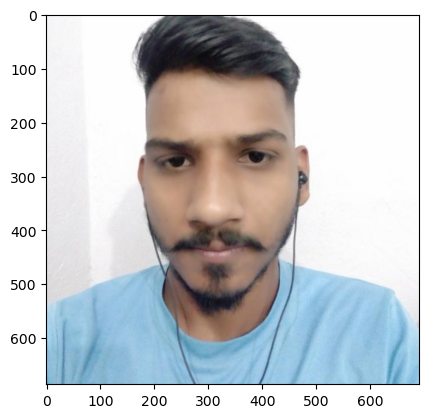

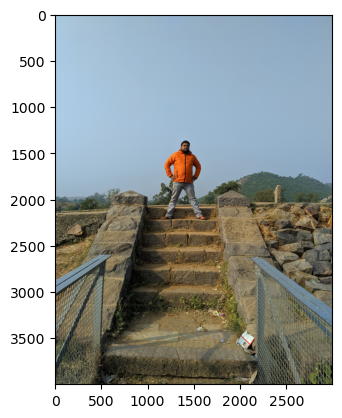

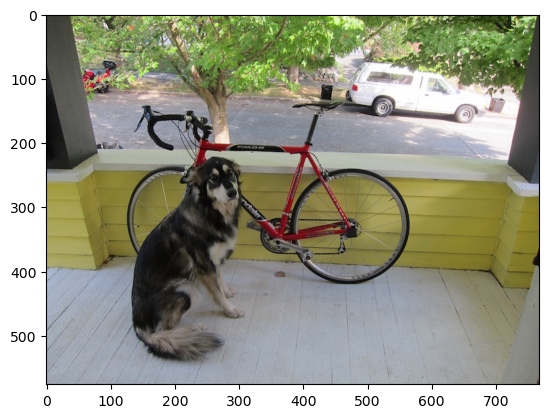

After Detection:
(608, 608, 3)


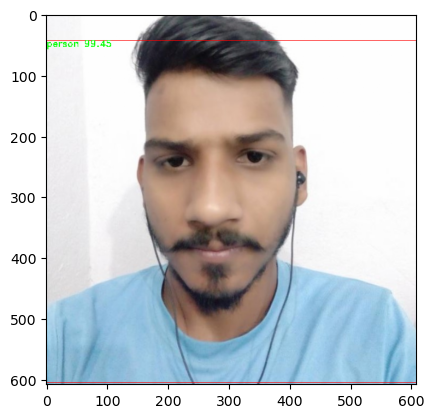

(608, 608, 3)


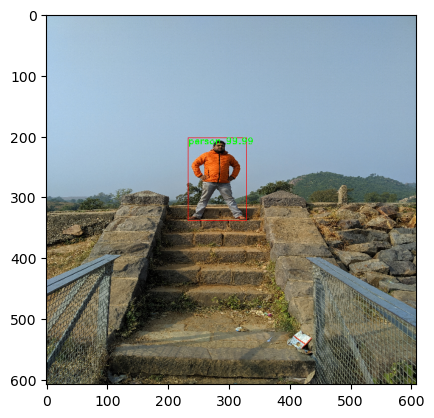

(608, 608, 3)


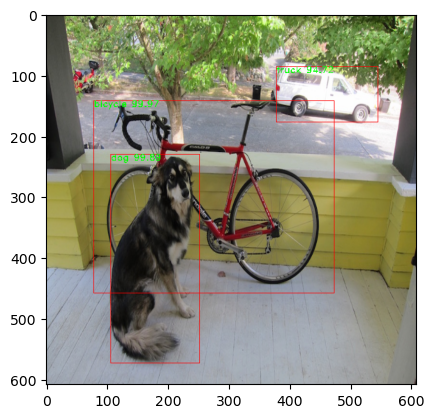

---------------------------------------------------------------------------------------------------------------------------

                            SUMMARY
 _ _ _ _ _ _ _ _ _ _ _ _  _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
|                Task                : Time Taken (in seconds) |
|--------------------------------------------------------------|
| Average time_per_img (3 images)    : 1.365   ( 4.096 )       |
|_ _ _ _ _ _ _ _ _ _ _ _  _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _|
---------------------------------------------------------------------------------------------------------------------------


In [10]:
import os
import cv2
import time
import torch
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset


class Folder(Dataset):
    def __init__(self, image_path):
        self.url = Find_URL(image_path)
        if len(self.url) == 0:
            try:
                self.files = [os.path.join(os.path.realpath('.'), image_path, img) for img in os.listdir(image_path)]
            except NotADirectoryError:
                self.files = []
                self.files.append(os.path.join(os.path.realpath('.'), image_path))
            except FileNotFoundError:
                print ("No file or directory with the name {}".format(image_path))
                exit()
        
#     def __getitem__(self, index):
#         if len(self.url) == 0:
#             img_path = self.files[index % len(self.files)]
#             img = np.array(
#                 Image.open(img_path).convert('RGB'),
#                 dtype=np.uint8)
#         else:
#             img_path = self.url[0]
#             img = read_url_image(img_path)

#         return img_path, img

    def __getitem__(self, index):
        if len(self.url) == 0:
            img_path = self.files[index % len(self.files)]
            img = np.array(
                Image.open(img_path).convert('BGR'),
                dtype=np.uint8)
        else:
            img_path = self.url[0]
            img = read_url_image(img_path, 'BGR')

        return img_path, img

    def __len__(self):
        if len(self.url) == 0:
            return len(self.files)
        else:
            return len(self.url)

# def load_data(img_path, batch_size, img_size, n_cpu=8):

#     dataset = Folder(
#         img_path)
    
#     image_path = []
#     for i in range(len(dataset)):
#         image_path.append(dataset[i][0])
    
#     dataloader = DataLoader(
#         dataset,
#         batch_size=batch_size,
#         shuffle=False,
#         num_workers=n_cpu,
#         pin_memory=True)
#     return dataloader, image_path

def load_data(img_path, batch_size, img_size, n_cpu=8):

    dataset = Folder(
        img_path)
    
    images = []
    for i in range(len(dataset)):
        images.append(dataset[i][1])
    
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=n_cpu,
        pin_memory=True)
    return dataloader, images

def detect(model_path, weights_path, image_path, classes, output_path,
                     batch_size=1, img_size=416, n_cpu=1, conf_thres=0.5, nms_thres=0.5, show=False, CUDA=True):
    """
    Detects objects on all images in specified directory or link
    
    """
    #Set up the neural network
    print("---------------------------------------------------------------------------------------------------------------------------")
    print("Loading network.....")
    model = load_model(model_path, weights_path, CUDA)
    print("Network successfully loaded")
    print("---------------------------------------------------------------------------------------------------------------------------")

    dataloader, images = load_data(image_path, batch_size, img_size, n_cpu)
    
    detected_image_path, outputs, original_images, times = detect_images(
        model,
        dataloader,
        images,
        output_path,
        img_size,
        batch_size,
        conf_thres,
        nms_thres,
        classes,
        CUDA)

    # torch.save(outputs, 'pred.pt')

    if show:  
        print('Before Detection:')
        for org_img in original_images:
            show_image(org_img)
    
        print('After Detection:')
        for det_img in detected_image_path:
            show_image_by_image_path(det_img)
        
    return times, detected_image_path


def detect_images(model, dataloader, image_path, output_path, img_size, batch_size, conf_thres, nms_thres, classes, CUDA):
    
    inp_dim = int(img_size)
    assert inp_dim % 32 == 0 
    assert inp_dim > 32

    #If there's a GPU availible, put the model on GPU
    if CUDA:
        model.cuda()

    #Set the model in evaluation model
    model.eval()

    # If the directory defined by the output_path flag (to save the detections), doesn't exist, create it.
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    image_path = sorted(image_path)
    
#     url = Find_URL(image_path[0])
#     if len(url) == 0:
#         images_array = [cv2.imread(x) for x in image_path]
#     else:
#         images_array = [read_url_image(url[0], mode='BGR')]
    images_array = image_path

    # PyTorch Variables for images
    image_batches = list(map(prepare_image, images_array, [inp_dim for x in range(len(image_path))], [img_size for x in range(len(image_path))]))

    processed_images, original_images, original_img_dims = [], [], []
    for batch in image_batches:
        processed_images.append(batch[0])
        original_images.append(batch[1])
        original_img_dims.append(batch[2])

    im_dim_list =  torch.FloatTensor(original_img_dims).repeat(1,2)
    if CUDA:
        im_dim_list = im_dim_list.cuda()
    
    left = 0
    if (len(im_dim_list) % batch_size):
        left = 1
        
    if batch_size != 1:
        num_batches = len(image_path) // batch_size + left          
        processed_images = [torch.cat((processed_images[i*batch_size : min((i +  1)*batch_size,
                            len(processed_images))]))  for i in range(num_batches)]
    
    detected_image_path = []
    outputs = []
    start_time = time.time()
    flag = 0
    for i, processed_image in enumerate(processed_images):
        
        #If there's a GPU availible, put the model on GPU
        if CUDA:
            processed_image = processed_image.cuda()

        # Load the images
        with torch.no_grad():
            prediction = model(processed_image)
        
        nc = prediction.shape[2]
        output = nms(prediction, conf_thres=conf_thres, nms_thres = nms_thres, num_classes=nc) 
    
        if type(output) == int:
            continue
    
        try:
            output
            print('Detection Succesfull')
        except NameError:
            print ("No detections were made")
            exit()
            
        
        output[..., 0] = output[..., 0]+ i + flag
        if batch_size > 1:
            flag += 1
        
        output = scaled_bbox(output, inp_dim, im_dim_list)
    
        a = list(map(lambda x: draw_bbox_and_save_image(x, original_images, image_path, inp_dim, output_path, classes, 
                                                        (0, 0, 255)), output))
        for i, im_pth in enumerate(a):
            if im_pth not in detected_image_path:
                detected_image_path.append(im_pth)

        outputs.append(output)
    end = time.time()
    
    times = { 'start_time': start_time, 'end_time': end }

    torch.cuda.empty_cache()
    return detected_image_path, outputs, images_array, times

def main():
    
    print_info()
    parser = argparse.ArgumentParser(description='YOLO v3 Detection Module')
    parser.add_argument('-f')
    parser.add_argument("-i", "--images", type=str, default="images/", help = "Image / Directory containing images to perform detection upon")
    parser.add_argument("-o", "--output_path", type = str, default="detected_image", help="Image / Directory to store detections to")
    parser.add_argument("-b", "--batch_size", type=int, default=2, help ="Batch size",)
    parser.add_argument("-m", "--model", type=str, default="cfg/yolov3.cfg", dest='cfgfile', help="Config file")
    parser.add_argument("-w", "--weights", type=str, default="weights/yolov3.weights", dest='weightsfile', help="weightsfile")
    parser.add_argument("-c", "--classes", type=str, default='data/coco.names', help='*.names path')
    parser.add_argument("-d", "--device", default='', help='device id (i.e. (0 or 1) or (cpu or gpu)')
    parser.add_argument("--conf_thres", type=float, default=0.4, help="Object Confidence to filter predictions")
    parser.add_argument("--nms_thres", type=float, default=0.5, help="IOU(NMS) Threshhold")
    parser.add_argument('--resolution', type=int, default=416, help='resizing size of image')
    parser.add_argument("--img_size", type=int, default=608, help="Input resolution of the network. Increase to increase accuracy. Decrease to increase speed")
    parser.add_argument("--n_cpu", type=int, default=os.cpu_count(), help="Number of cpu threads to use during batch generation")
    parser.add_argument("-show", "--show", type=bool, default=True, help="Show the image")
    
    args = parser.parse_args()
    print(f"Model: {args}")

    # Extract class names from file
    classes = load_classes(args.classes)  # List of class names

    times, image_path = detect(
        args.cfgfile,
        args.weightsfile,
        args.images,
        classes,
        args.output_path,
        batch_size=int(args.batch_size),
        img_size=args.img_size,
        n_cpu=int(args.n_cpu),
        conf_thres=float(args.conf_thres),
        nms_thres=float(args.nms_thres),
        show=args.show,
        CUDA = False if args.device in ['', 0, '0', 'cpu'] else True)
    
    # SUMMARY BOARD
    write_summary(times, image_path)
    
if __name__ == '__main__':
    main()

(686, 692, 3)


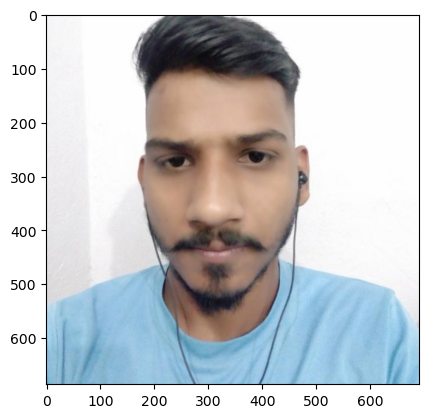

In [34]:
show_image_by_image_path('images/1.jpg')

#### videos detection

In [ ]:
import cv2
import time
import matplotlib.pyplot as plt

videofile = "1.mp4" #or path to the video file. 

cap = cv2.VideoCapture(videofile)  

# cap = cv2.VideoCapture(0)  #for webcam

assert cap.isOpened(), 'Cannot capture source'

frames = 0
frames = 0  
start = time.time()
while cap.isOpened():
    ret, frame = cap.read()
    
    if ret:   
        proc_img, org_img, org_img_dim = prep_image(frame, inp_dim, resolution)
        # cv2.imshow("a", frame)
        im_dim = frame.shape[1], frame.shape[0]
        im_dim = torch.FloatTensor(im_dim).repeat(1,2)
        
        if CUDA:
            im_dim = im_dim.cuda()
            img = proc_img.cuda()

        prediction = model(img)
        
        num_classes = prediction.shape[2]
        output = final_prediction(prediction, conf_thres, iou_thres, num_classes)

        if type(output) == int:
            frames += 1
            print("FPS of the video is {:5.4f}".format( frames / (time.time() - start)))
            cv2.imshow("frame", frame)
            key = cv2.waitKey(1)
            if key & 0xFF == ord('q'):
                break
            continue
        output[:,1:5] = torch.clamp(output[:,1:5], 0.0, float(inp_dim))

        im_dim = im_dim.repeat(output.size(0), 1)/inp_dim
        output[:,1:5] *= im_dim

        classes = load_classes(names_file)

        list(map(lambda x: draw_bbox(x, frame, (0,0,255), videofile), output))
        
        # cv2.imshow("frame", frame)
        # key = cv2.waitKey(1)
        # if key & 0xFF == ord('q'):
        #    break
        
        plt.imshow(frame, cmap = 'gray', interpolation = 'bicubic')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.show()

        frames += 1
        print(time.time() - start)
        print("FPS of the video is {:5.2f}".format( frames / (time.time() - start)))
    else:
        break    

In [ ]:
import tqdm

from terminaltables import AsciiTable


from pytorchyolo.utils.utils import ap_per_class, get_batch_statistics
from pytorchyolo.utils.datasets import ListDataset
from pytorchyolo.utils.transforms import DEFAULT_TRANSFORMS


def evaluate_model_file(model_path, weights_path, img_path, class_names, batch_size=8, img_size=416,
                        n_cpu=8, iou_thres=0.5, conf_thres=0.5, nms_thres=0.5, verbose=True):

    dataloader = _create_validation_data_loader(
        img_path, batch_size, img_size, n_cpu)
    
    model = load_model(model_path, weights_path)
    
    metrics_output = _evaluate(
        model,
        dataloader,
        class_names,
        img_size,
        iou_thres,
        conf_thres,
        nms_thres,
        verbose)
    
    return metrics_output


def print_eval_stats(metrics_output, class_names, verbose):
    if metrics_output is not None:
        precision, recall, AP, f1, ap_class = metrics_output
        if verbose:
            # Prints class AP and mean AP
            ap_table = [["Index", "Class", "AP"]]
            for i, c in enumerate(ap_class):
                ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
            print(AsciiTable(ap_table).table)
        print(f"---- mAP {AP.mean():.5f} ----")
    else:
        print("---- mAP not measured (no detections found by model) ----")


def _evaluate(model, dataloader, class_names, img_size, iou_thres, conf_thres, nms_thres, verbose):

    model.eval()  # Set model to evaluation mode

    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    labels = []
    sample_metrics = []  # List of tuples (TP, confs, pred)
    for _, imgs, targets in tqdm.tqdm(dataloader, desc="Validating"):
        # Extract labels
        labels += targets[:, 1].tolist()
        # Rescale target
        targets[:, 2:] = xywh2xyxy(targets[:, 2:])
        targets[:, 2:] *= img_size

        imgs = Variable(imgs.type(Tensor), requires_grad=False)

        with torch.no_grad():
            outputs = model(imgs)
            outputs = non_max_suppression(outputs, conf_thres=conf_thres, iou_thres=nms_thres)

        sample_metrics += get_batch_statistics(outputs, targets, iou_threshold=iou_thres)

    if len(sample_metrics) == 0:  # No detections over whole validation set.
        print("---- No detections over whole validation set ----")
        return None

    # Concatenate sample statistics
    true_positives, pred_scores, pred_labels = [
        np.concatenate(x, 0) for x in list(zip(*sample_metrics))]
    metrics_output = ap_per_class(
        true_positives, pred_scores, pred_labels, labels)

    print_eval_stats(metrics_output, class_names, verbose)

    return metrics_output


def _create_validation_data_loader(img_path, batch_size, img_size, n_cpu):
    
    dataset = ListDataset(img_path, img_size=img_size, multiscale=False, transform=DEFAULT_TRANSFORMS)
    
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=n_cpu,
        pin_memory=True,
        collate_fn=dataset.collate_fn)
    return dataloader


def run():
    print_environment_info()
    parser = argparse.ArgumentParser(description="Evaluate validation data.")
    parser.add_argument("-m", "--model", type=str, default="config/yolov3.cfg", help="Path to model definition file (.cfg)")
    parser.add_argument("-w", "--weights", type=str, default="weights/yolov3.weights", help="Path to weights or checkpoint file (.weights or .pth)")
    parser.add_argument("-d", "--data", type=str, default="config/coco.data", help="Path to data config file (.data)")
    parser.add_argument("-b", "--batch_size", type=int, default=8, help="Size of each image batch")
    parser.add_argument("-v", "--verbose", action='store_true', help="Makes the validation more verbose")
    parser.add_argument("--img_size", type=int, default=416, help="Size of each image dimension for yolo")
    parser.add_argument("--n_cpu", type=int, default=8, help="Number of cpu threads to use during batch generation")
    parser.add_argument("--iou_thres", type=float, default=0.5, help="IOU threshold required to qualify as detected")
    parser.add_argument("--conf_thres", type=float, default=0.01, help="Object confidence threshold")
    parser.add_argument("--nms_thres", type=float, default=0.4, help="IOU threshold for non-maximum suppression")
    args = parser.parse_args()
    print(f"Command line arguments: {args}")

    # Load configuration from data file
    data_config = parse_data_config(args.data)
    # Path to file containing all images for validation
    valid_path = data_config["valid"]
    class_names = load_classes(data_config["names"])  # List of class names

    precision, recall, AP, f1, ap_class = evaluate_model_file(
        args.model,
        args.weights,
        valid_path,
        class_names,
        batch_size=args.batch_size,
        img_size=args.img_size,
        n_cpu=args.n_cpu,
        iou_thres=args.iou_thres,
        conf_thres=args.conf_thres,
        nms_thres=args.nms_thres,
        verbose=True)


if __name__ == "__main__":
    run()

In [8]:
from torch.utils.data import Dataset

class ListDataset(Dataset):
    def __init__(self, list_path, img_size=416, multiscale=True, transform=None):
        with open(list_path, "r") as file:
            self.img_files = file.readlines()

        self.label_files = []
        for path in self.img_files:
            image_dir = os.path.dirname(path)
            label_dir = "labels".join(image_dir.rsplit("images", 1))
            assert label_dir != image_dir, \
                f"Image path must contain a folder named 'images'! \n'{image_dir}'"
            label_file = os.path.join(label_dir, os.path.basename(path))
            label_file = os.path.splitext(label_file)[0] + '.txt'
            self.label_files.append(label_file)

        self.img_size = img_size
        self.max_objects = 100
        self.multiscale = multiscale
        self.min_size = self.img_size - 3 * 32
        self.max_size = self.img_size + 3 * 32
        self.batch_count = 0
        self.transform = transform

    def __getitem__(self, index):

        # ---------
        #  Image
        # ---------
        try:

            img_path = self.img_files[index % len(self.img_files)].rstrip()

            img = np.array(Image.open(img_path).convert('RGB'), dtype=np.uint8)
        except Exception:
            print(f"Could not read image '{img_path}'.")
            return

        # ---------
        #  Label
        # ---------
        try:
            label_path = self.label_files[index % len(self.img_files)].rstrip()

            # Ignore warning if file is empty
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                boxes = np.loadtxt(label_path).reshape(-1, 5)
        except Exception:
            print(f"Could not read label '{label_path}'.")
            return

        # -----------
        #  Transform
        # -----------
        if self.transform:
            try:
                img, bb_targets = self.transform((img, boxes))
            except Exception:
                print("Could not apply transform.")
                return

        return img_path, img, bb_targets

In [ ]:
img_path, img, bb = ListDataset()

#### utils/loss.py

In [ ]:
import os
import time
import platform
import tqdm
import torch
import torch.nn as nn
import torchvision
import numpy as np
import subprocess
import random
import math


def compute_loss(predictions, targets, model):
    # Check which device was used
    device = targets.device

    # Add placeholder varables for the different losses
    lcls, lbox, lobj = torch.zeros(1, device=device), torch.zeros(1, device=device), torch.zeros(1, device=device)

    # Build yolo targets
    tcls, tbox, indices, anchors = build_targets(predictions, targets, model)  # targets

    # Define different loss functions classification
    BCEcls = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([1.0], device=device))
    BCEobj = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([1.0], device=device))

    # Calculate losses for each yolo layer
    for layer_index, layer_predictions in enumerate(predictions):
        # Get image ids, anchors, grid index i and j for each target in the current yolo layer
        b, anchor, grid_j, grid_i = indices[layer_index]
        # Build empty object target tensor with the same shape as the object prediction
        tobj = torch.zeros_like(layer_predictions[..., 0], device=device)  # target obj
        # Get the number of targets for this layer.
        # Each target is a label box with some scaling and the association of an anchor box.
        # Label boxes may be associated to 0 or multiple anchors. So they are multiple times or not at all in the targets.
        num_targets = b.shape[0]
        # Check if there are targets for this batch
        if num_targets:
            # Load the corresponding values from the predictions for each of the targets
            ps = layer_predictions[b, anchor, grid_j, grid_i]

            # Regression of the box
            # Apply sigmoid to xy offset predictions in each cell that has a target
            pxy = ps[:, :2].sigmoid()
            # Apply exponent to wh predictions and multiply with the anchor box that matched best with the label for each cell that has a target
            pwh = torch.exp(ps[:, 2:4]) * anchors[layer_index]
            # Build box out of xy and wh
            pbox = torch.cat((pxy, pwh), 1)
            # Calculate CIoU or GIoU for each target with the predicted box for its cell + anchor
            iou = bbox_iou(pbox.T, tbox[layer_index], x1y1x2y2=False, CIoU=True)
            # We want to minimize our loss so we and the best possible IoU is 1 so we take 1 - IoU and reduce it with a mean
            lbox += (1.0 - iou).mean()  # iou loss

            # Classification of the objectness
            # Fill our empty object target tensor with the IoU we just calculated for each target at the targets position
            tobj[b, anchor, grid_j, grid_i] = iou.detach().clamp(0).type(tobj.dtype)  # Use cells with iou > 0 as object targets

            # Classification of the class
            # Check if we need to do a classification (number of classes > 1)
            if ps.size(1) - 5 > 1:
                # Hot one class encoding
                t = torch.zeros_like(ps[:, 5:], device=device)  # targets
                t[range(num_targets), tcls[layer_index]] = 1
                # Use the tensor to calculate the BCE loss
                lcls += BCEcls(ps[:, 5:], t)  # BCE

        # Classification of the objectness the sequel
        # Calculate the BCE loss between the on the fly generated target and the network prediction
        lobj += BCEobj(layer_predictions[..., 4], tobj) # obj loss

    lbox *= 0.05
    lobj *= 1.0
    lcls *= 0.5

    # Merge losses
    loss = lbox + lobj + lcls

    return loss, torch.cat((lbox, lobj, lcls, loss)).detach().cpu()

def build_targets(p, targets, model):
    # Build targets for compute_loss(), input targets(image,class,x,y,w,h)
    na, nt = 3, targets.shape[0]  # number of anchors, targets #TODO
    tcls, tbox, indices, anch = [], [], [], []
    gain = torch.ones(7, device=targets.device)  # normalized to gridspace gain
    # Make a tensor that iterates 0-2 for 3 anchors and repeat that as many times as we have target boxes
    ai = torch.arange(na, device=targets.device).float().view(na, 1).repeat(1, nt)
    # Copy target boxes anchor size times and append an anchor index to each copy the anchor index is also expressed by the new first dimension
    targets = torch.cat((targets.repeat(na, 1, 1), ai[:, :, None]), 2)

    for i, yolo_layer in enumerate(model.yolo_layers):
        # Scale anchors by the yolo grid cell size so that an anchor with the size of the cell would result in 1
        anchors = yolo_layer.anchors / yolo_layer.stride
        # Add the number of yolo cells in this layer the gain tensor
        # The gain tensor matches the collums of our targets (img id, class, x, y, w, h, anchor id)
        gain[2:6] = torch.tensor(p[i].shape)[[3, 2, 3, 2]]  # xyxy gain
        # Scale targets by the number of yolo layer cells, they are now in the yolo cell coordinate system
        t = targets * gain
        # Check if we have targets
        if nt:
            # Calculate ration between anchor and target box for both width and height
            r = t[:, :, 4:6] / anchors[:, None]
            # Select the ratios that have the highest divergence in any axis and check if the ratio is less than 4
            j = torch.max(r, 1. / r).max(2)[0] < 4  # compare #TODO
            # Only use targets that have the correct ratios for their anchors
            # That means we only keep ones that have a matching anchor and we loose the anchor dimension
            # The anchor id is still saved in the 7th value of each target
            t = t[j]
        else:
            t = targets[0]

        # Extract image id in batch and class id
        b, c = t[:, :2].long().T
        # We isolate the target cell associations.
        # x, y, w, h are allready in the cell coordinate system meaning an x = 1.2 would be 1.2 times cellwidth
        gxy = t[:, 2:4]
        gwh = t[:, 4:6]  # grid wh
        # Cast to int to get an cell index e.g. 1.2 gets associated to cell 1
        gij = gxy.long()
        # Isolate x and y index dimensions
        gi, gj = gij.T  # grid xy indices

        # Convert anchor indexes to int
        a = t[:, 6].long()
        # Add target tensors for this yolo layer to the output lists
        # Add to index list and limit index range to prevent out of bounds
        indices.append((b, a, gj.clamp_(0, gain[3] - 1), gi.clamp_(0, gain[2] - 1)))
        # Add to target box list and convert box coordinates from global grid coordinates to local offsets in the grid cell
        tbox.append(torch.cat((gxy - gij, gwh), 1))  # box
        # Add correct anchor for each target to the list
        anch.append(anchors[a])
        # Add class for each target to the list
        tcls.append(c)

    return tcls, tbox, indices, anch

#### utils/logger.py

In [ ]:
import os
import datetime
from torch.utils.tensorboard import SummaryWriter


class Logger(object):
    def __init__(self, log_dir, log_hist=True):
        """Create a summary writer logging to log_dir."""
        if log_hist:    # Check a new folder for each log should be dreated
            log_dir = os.path.join(
                log_dir,
                datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S"))
        self.writer = SummaryWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        self.writer.add_scalar(tag, value, step)

    def list_of_scalars_summary(self, tag_value_pairs, step):
        """Log scalar variables."""
        for tag, value in tag_value_pairs:
            self.writer.add_scalar(tag, value, step)